In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import xlrd

from sqlalchemy import create_engine, text, Integer, String, Column
from sqlalchemy.exc import SQLAlchemyError
from sqlalchemy.ext.declarative import declarative_base

# Etapa 1 - Extração e Carregamento dos Dados

- ✅ **Escolha dos Dados**: Escolher um conjunto de dados que seja relevante para o candidato e que permita a aplicação de técnicas de análise de dados.
- ✅ **Extração**: Utilizar a linguagem de programação Python e bibliotecas como requests, pandas, sqlalchemy para extrair os dados da fonte escolhida.
- ✅ **Transformação**: Limpar e transformar os dados para garantir a qualidade e consistência.
- ❎ **Carregamento**: Carregar os dados transformados em um banco de dados relacional (PostgreSQL, MySQL, etc.), utilizando o SQLAlchemy para a conexão e inserção dos dados.


## **Escolha, Extração e Transformação dos Dados**

### Tabela 1: Projeções  FEITO

In [43]:
# Lendo o arquivo xlsx
# Excluída as 6 primeiras linhas, visto que não são necessárias para a manipulação dos dados
projecoes_df = pd.read_excel("Tabelas/projecoes_2024_tab4_indicadores.xlsx", skiprows=6)

# Filtrar linhas e colunas necessárias
projecoes2_df_filtrado = projecoes_df[
    (projecoes_df["LOCAL"].str.strip() == "Brasil") &                                                     # LOCAL == "Brasil" 
    (projecoes_df["ANO"].astype(float).between(2018, 2024) | (projecoes_df["ANO"].astype(float) == 2045)) # ANO no intervalo [2018, 2025] ou [2045]
]

# Selecionar apenas as colunas desejadas
colunas_desejadas = ["ANO", "LOCAL", "POP_H", "POP_M", "e0_T", "e60_T"]
projecoes2_df_filtrado = projecoes2_df_filtrado[colunas_desejadas]

projecoes2_df_filtrado

,ANO,LOCAL,POP_H,POP_M,e0_T,e60_T
18,2018,Brasil,100895555,105633483,75.990227,22.206781
19,2019,Brasil,101551234,106348865,76.221101,22.254800
20,2020,Brasil,102140954,107023935,74.809005,21.169615
21,2021,Brasil,102550853,107552789,72.784302,20.084039
22,2022,Brasil,102875114,107987869,75.448044,21.619386
23,2023,Brasil,103251553,108443605,76.388455,22.470774
24,2024,Brasil,103662286,108921464,76.605711,22.590940
45,2045,Brasil,106861156,113184535,80.540082,24.724144


### Tabela 2: Perfil etário  FEITO

In [73]:
# Definindo as colunas que queremos manter e renomear
colunas_desejadas = {
    "Características selecionadas": "features",
    "População na força de trabalho\n(1 000 pessoas)": "work_pop"
}

# Lista com os anos
anos = ["2018", "2019", "2020", "2021", "2022", "2023"]

# Lendo os arquivos XLS, filtrando apenas as colunas desejadas e renomeando
dataframes = {
    f"etario{ano}_df": pd.read_excel(
        "Tabelas/tabela_1_1_Indic_BR.xls",
        sheet_name=ano,
        skiprows=2,
        usecols=list(colunas_desejadas.keys())
    ).rename(columns=colunas_desejadas)
    .assign(year=ano)  # Adiciona a coluna "ano"
    
    for ano in anos
}

# Dicionário de faixas para os subconjuntos
faixas = {
    # "total": (5, 13),    # Total: linhas 9 a 16 -> índices ajustados 5 a 12
    "homens": (15, 22),  # Homens: linhas 18 a 25 -> índices ajustados 14 a 21
    "mulheres": (24, 31) # Mulheres: linhas 27 a 34 -> índices ajustados 23 a 30
    # 'branca': (32:40),
    # 'preta_parda': (41:49)
}

# Função otimizada para processar os subconjuntos e adicionar a coluna "sexo"
def processar_etario(df):
    # Para cada faixa (homens, mulheres), filtramos as linhas e adicionamos a coluna "sexo"
    return {
        chave: df.iloc[inicio:fim].assign(sex='H' if chave == 'homens' else 'M')
        for chave, (inicio, fim) in faixas.items()
    }

# Criando um dicionário com os subconjuntos de cada DataFrame
etario_filtrado = {nome: processar_etario(df) for nome, df in dataframes.items()}

conjunto_etario = []

for etario, subconjuntos in etario_filtrado.items():
    for faixa, df in subconjuntos.items():
        conjunto_etario.append(df)
    
etario_filtrado = pd.concat(conjunto_etario, axis=0, ignore_index=True)

etario_filtrado = etario_filtrado[["year", "sex", "features", "work_pop"]]

etario_filtrado["work_pop"] = etario_filtrado["work_pop"] * 1000

# Remover as linhas onde a coluna 'features' é '14 a 17 anos' ou '18 a 24 anos'
etario_filtrado = etario_filtrado[~etario_filtrado["features"].isin(["14 a 17 anos", "18 a 24 anos", "25 a 29 anos"])]

# Reiniciar os índices
etario_filtrado = etario_filtrado.reset_index(drop=True)

# etario_filtrado

In [74]:
# Definindo as colunas que queremos manter e renomear
colunas_desejadas = {
    "Características selecionadas": "degree",
    "População na força de trabalho\n(1 000 pessoas)": "work_pop"
}

# Lista com os anos
anos = ["2018", "2019", "2020", "2021", "2022", "2023"]

# Lendo os arquivos XLS, filtrando apenas as colunas desejadas e renomeando
dataframes = {
    f"socio{ano}_df": pd.read_excel(
        "Tabelas/tabela_1_1_Indic_BR.xls",
        sheet_name=ano,
        skiprows=2,
        usecols=list(colunas_desejadas.keys())
    ).rename(columns=colunas_desejadas)
    .assign(year=ano)  # Adiciona a coluna "ano"
    
    for ano in anos
}

# Dicionário de faixas para os subconjuntos
faixas = {
    # "total": (5, 13),    # Total: linhas 9 a 16 -> índices ajustados 5 a 12
    "homens": (58, 62),  # Homens: linhas 18 a 25 -> índices ajustados 14 a 21
    "mulheres": (64, 68) # Mulheres: linhas 27 a 34 -> índices ajustados 23 a 30
    # 'branca': (32:40),
    # 'preta_parda': (41:49)
}

# Função otimizada para processar os subconjuntos e adicionar a coluna "sexo"
def processar_socio(df):
    # Para cada faixa (homens, mulheres), filtramos as linhas e adicionamos a coluna "sexo"
    return {
        chave: df.iloc[inicio:fim].assign(sex='H' if chave == 'homens' else 'M')
        for chave, (inicio, fim) in faixas.items()
    }

# Criando um dicionário com os subconjuntos de cada DataFrame
socio_filtrado = {nome: processar_socio(df) for nome, df in dataframes.items()}

conjunto_socio = []

for socio, subconjuntos in socio_filtrado.items():
    for faixa, df in subconjuntos.items():
        conjunto_socio.append(df)
    
socio_filtrado = pd.concat(conjunto_socio, axis=0, ignore_index=True)

socio_filtrado = socio_filtrado[["year", "sex", "degree", "work_pop"]]

socio_filtrado["work_pop"] = socio_filtrado["work_pop"] * 1000

socio_filtrado

,year,sex,degree,work_pop
0,2018,H,Sem instrução ou fundamental incompleto,1.779664e+07
1,2018,H,Ensino fundamental completo ou médio incompleto,1.032244e+07
2,2018,H,Ensino médio completo ou superior incompleto,2.256167e+07
3,2018,H,Ensino superior completo,8.607003e+06
4,2018,M,Sem instrução ou fundamental incompleto,8.985535e+06
5,2018,M,Ensino fundamental completo ou médio incompleto,6.731356e+06
6,2018,M,Ensino médio completo ou superior incompleto,1.979529e+07
7,2018,M,Ensino superior completo,1.082206e+07
8,2019,H,Sem instrução ou fundamental incompleto,1.725747e+07
9,2019,H,Ensino fundamental completo ou médio incompleto,1.045919e+07


### Tabela 3: Perfil socio/econômico TERMINAR

In [25]:
# Lendo o arquivo xls
# Excluída as 2 primeiras linhas, visto que não são necessárias para a manipulação dos dados
socio18_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2018", skiprows=2)
socio19_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2019", skiprows=2)
socio20_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2020", skiprows=2)
socio21_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2021", skiprows=2)
socio22_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2022", skiprows=2)
socio23_df = pd.read_excel("Tabelas/tabela_1_1_Indic_BR.xls", sheet_name="2023", skiprows=2)

def processar_socio(df):
    
    # Separar em subconjuntos
    total_df = df.iloc[55-4:60-4]  # Total [55:59]
    homens_df = df.iloc[61-4:66-4]  # Homens [61:65]
    mulheres_df = df.iloc[67-4:72-4]  # Mulheres [67:71]
    branca_df = df.iloc[73-4:78-4]  # Branca [73:77]
    preta_parda_df = df.iloc[79-4:84-4]  # Preta ou parda [79:83]
    
    # Retornar os subconjuntos como um dicionário (para fácil acesso)
    return {
        'total': total_df,
        'homens': homens_df,
        'mulheres': mulheres_df,
        'branca': branca_df,
        'preta_parda': preta_parda_df
    }

# Lista com os DataFrames
dataframes = [socio18_df, socio19_df, socio20_df, socio21_df, socio22_df, socio23_df]

# Dicionário para armazenar os subconjuntos de cada DataFrame
resultados = {}

for i, df in enumerate(dataframes, start=18):
    # Processar o DataFrame atual
    subconjuntos = processar_socio(df)
    
    # Armazenar os subconjuntos no dicionário
    resultados[f'socio{i}_df'] = subconjuntos

# # Exibindo os subconjuntos (opcional)
resultados['socio18_df']['total']

,Características selecionadas,População em idade de trabalhar\n(1 000 pessoas),População na força de trabalho\n(1 000 pessoas),População ocupada\n(1 000 pessoas),População ocupada em trabalhos formais (1)\n(1 000 pessoas),População desocupada\n(1 000 pessoas),População na força de trabalho potencial\n(1 000 pessoas),População subutilizada\n(1 000 pessoas),Taxa de participação (%),Nível de ocupação (%),Taxa de formalização (%),Taxa de desocupação (%),Taxa composta de subutilização (%)
51,Total,166576.290000,105621.988924,92771.358454,54504.240877,12850.630470,8261.794278,28082.380141,63.407577,55.693015,58.751151,12.166624,24.658805
52,Sem instrução ou fundamental incompleto,58402.318920,26782.175393,23681.469242,9093.344674,3100.706151,3458.114658,9052.904336,45.858068,40.548851,38.398566,11.577499,29.936566
53,Ensino fundamental completo ou médio incompleto,29029.255342,17053.798518,14207.574577,7083.307005,2846.223940,2029.636246,6151.606576,58.746938,48.942263,49.855850,16.689677,32.235322
54,Ensino médio completo ou superior incompleto,55822.330986,42356.954721,36629.671612,24104.610580,5727.283110,2329.847983,10365.597137,75.878155,65.618313,65.806243,13.521470,23.196104
55,Ensino superior completo,23322.384752,19429.060293,18252.643024,14222.978619,1176.417269,444.195391,2512.272092,83.306491,78.262336,77.922844,6.054937,12.641472


## **Carregamento**  TERMINAR

In [ ]:
# Defina as credenciais do MySQL
user = "root"
password = "admin"
host = "0.0.0.0"  # ou IP do servidor
database_name = "projecoes2_banco"

# Crie a engine de conexão sem especificar um banco de dados
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}")

# Crie a base para definir as tabelas
Base = declarative_base()

# Defina a tabela com chave primária
class Projecao(Base):
    __tablename__ = "projecoes2_table"
    
    ano = Column(Integer, primary_key=True)  # Definindo a chave primária
    local = Column(String(50))
    pop_t = Column(Integer)
    pop_h = Column(Integer)
    pop_m = Column(Integer)
    e0_t = Column(Integer)
    e60_t = Column(Integer)

# Crie o banco de dados se não existir
try:
    with engine.connect() as connection:
        connection.execute(text(f"CREATE DATABASE IF NOT EXISTS {database_name};"))
        print(f"Banco de dados '{database_name}' criado com sucesso!")
except SQLAlchemyError as e:
    print(f"Erro ao criar o banco de dados: {e}")

# Criar a tabela dentro do banco de dados
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database_name}")

try:
    Base.metadata.create_all(engine)  # Criação da tabela
    print("Tabela 'projecoes2_table' criada com sucesso!")
except SQLAlchemyError as e:
    print(f"Erro ao criar a tabela: {e}")

# Inserir os dados do DataFrame na tabela
try:
    # A variável projecoes2_df_filtrado deve ser um DataFrame pandas
    projecoes2_df_filtrado.to_sql('projecoes2_table', con=engine, if_exists='append', index=False)
    print("Dados inseridos com sucesso na tabela 'projecoes2_table'!")
except SQLAlchemyError as e:
    print(f"Erro ao inserir os dados: {e}")


Banco de dados 'projecoes2_banco' criado com sucesso!
Tabela 'projecoes2_table' criada com sucesso!
Dados inseridos com sucesso na tabela 'projecoes2_table'!


# Etapa 2 - Modelagem dos Dados com DBT
- **Criação do Projeto**: Criar um projeto DBT e conectar ao banco de dados criado na etapa anterior.
- **Modelagem**: Criar modelos DBT para transformar os dados brutos em um modelo dimensional, com tabelas ou views.
- **Cálculos**: Realizar cálculos de agregação, criar views e tabelas intermediárias para preparar os dados para a geração de relatórios.
- **Documentação**: Documentar os modelos DBT utilizando a linguagem YAML, explicando a lógica de cada modelo.


# Etapa 3: Criação de um Relatório ou Dashboard (Opcional)

- **Escolha da Ferramenta**: Utilizar uma ferramenta de BI (Business Intelligence) como Tableau, Power BI ou uma biblioteca de visualização em Python (matplotlib, seaborn) para criar um relatório ou dashboard.
- **Visualização**: Criar visualizações que respondam a perguntas de negócio relevantes e que permitam uma fácil interpretação dos dados.


### GRÁFICOS - Tabela 1: Projeções FEITO

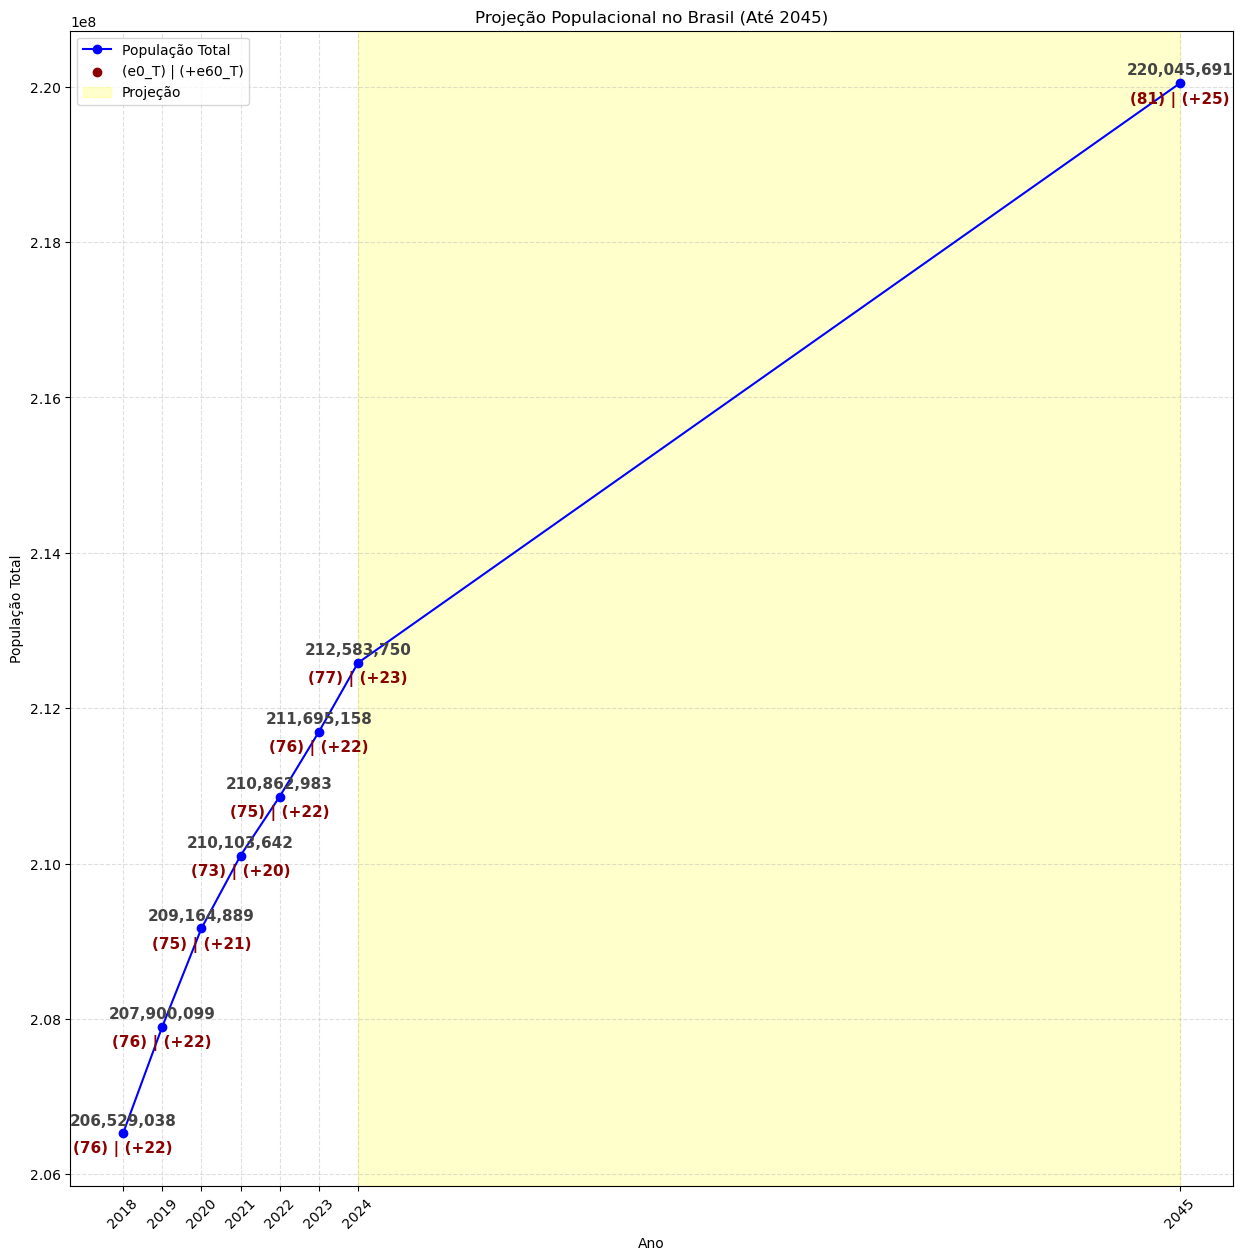

In [50]:
# Criar o gráfico principal
plt.figure(figsize=(15, 15))

pop_T = projecoes2_df_filtrado["POP_H"]+projecoes2_df_filtrado["POP_M"]

plt.plot(projecoes2_df_filtrado["ANO"], pop_T,
         marker="o", linestyle="-", color="b", label="População Total")

# Adicionar valores nos pontos do gráfico
for ano, pop, e0_T, e60_T in zip(projecoes2_df_filtrado["ANO"], 
                                 projecoes2_df_filtrado["POP_H"]+projecoes2_df_filtrado["POP_M"], 
                                 projecoes2_df_filtrado["e0_T"], 
                                 projecoes2_df_filtrado["e60_T"]):
    plt.text(ano, pop + (pop * 0.0005), f"{pop:,.0f}", 
             ha="center", fontsize=11, color="#444444", fontweight="bold")

    plt.text(ano, pop - (pop * 0.0012), f"({e0_T:,.0f}) | (+{e60_T:,.0f})", 
             ha="center", fontsize=11, color="darkred", fontweight="bold")

# Criar um marcador invisível para incluir na legenda
plt.scatter([], [], color="darkred", label="(e0_T) | (+e60_T)")

# Destacar uma região com transparência (exemplo: entre os anos 2024 e 2045)
plt.axvspan(2024, 2045, color="yellow", alpha=0.2, label="Projeção")

# Personalização
plt.xlabel("Ano")
plt.ylabel("População Total")
plt.title("Projeção Populacional no Brasil (Até 2045)")
plt.xticks(projecoes2_df_filtrado["ANO"], rotation=45)  # Rotacionar anos no eixo x
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

# Mostrar o gráfico
plt.show()


### GRÁFICOS - Tabela 2: Perfil etário FEITO

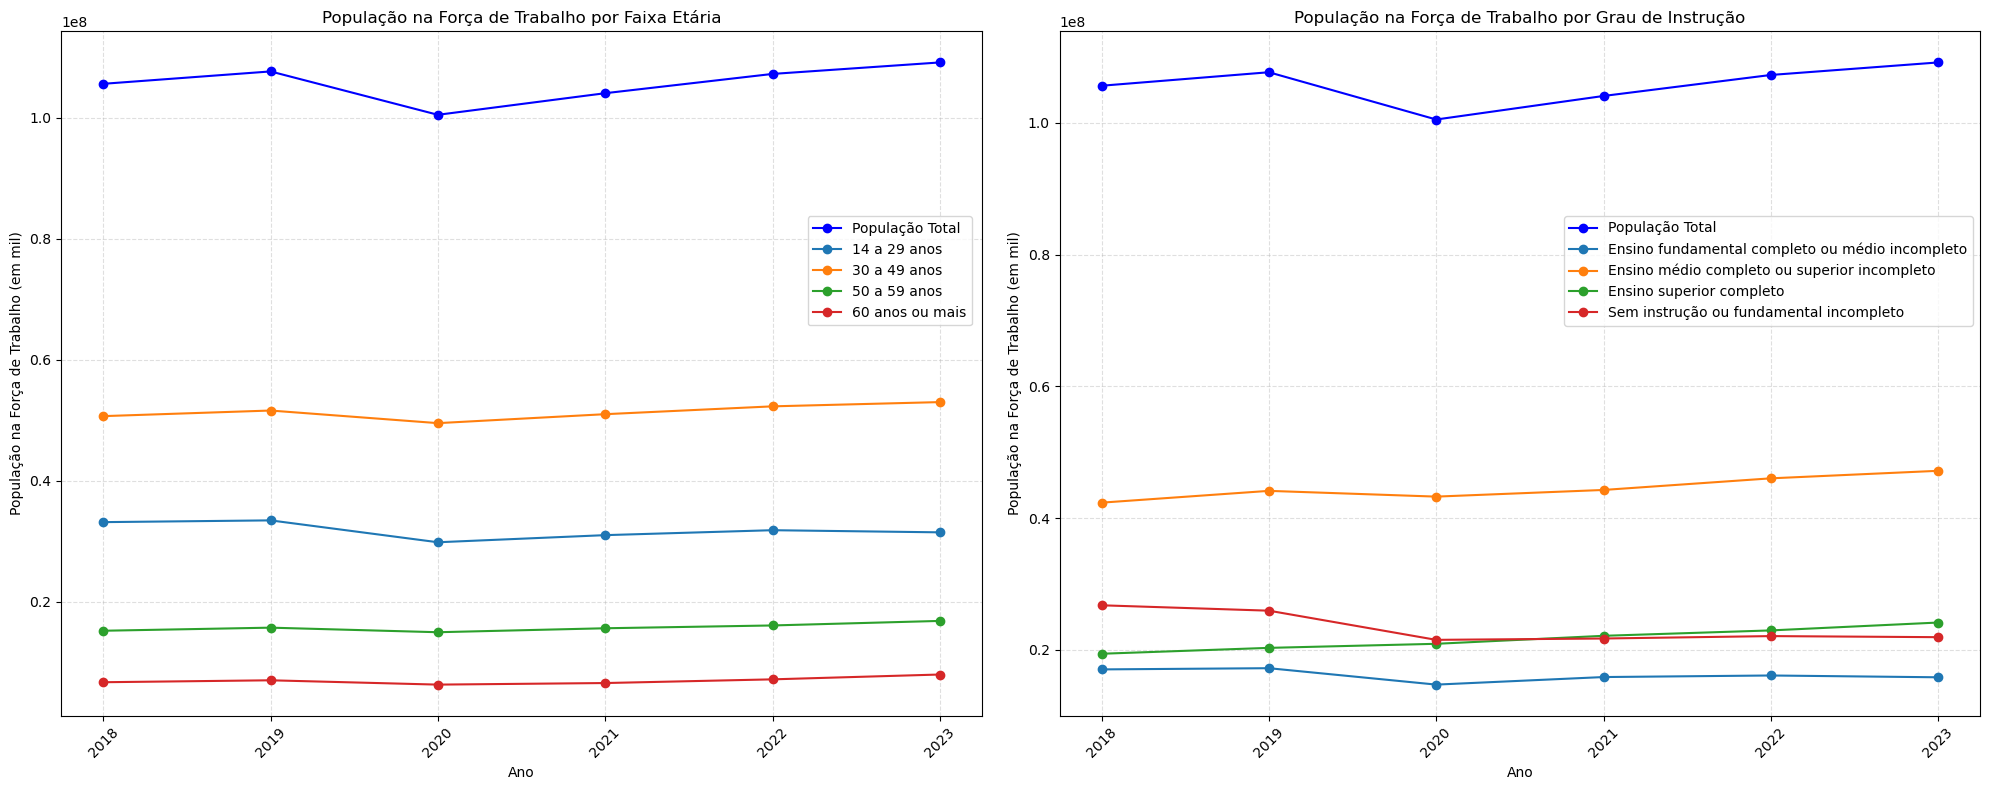

In [110]:
# Criar o gráfico com 1 linha e 2 colunas
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Gráfico 1: População por faixa etária ao longo dos anos
axs[0].plot(etario_filtrado["year"].unique(), 
            etario_filtrado.groupby("year")["work_pop"].sum(), 
            marker="o", linestyle="-", color="b", label="População Total")

# Definindo as faixas etárias
faixas_etarias = [
    "14 a 29 anos", 
    "30 a 49 anos", 
    "50 a 59 anos", 
    "60 anos ou mais"
]

# Iterando sobre as faixas etárias e gerando o gráfico para cada uma
for faixa in faixas_etarias:
    faixa_data = etario_filtrado[etario_filtrado["features"] == faixa]
    axs[0].plot(faixa_data["year"].unique(), 
                faixa_data.groupby("year")["work_pop"].sum(), 
                marker="o", linestyle="-", label=faixa)

# Adicionar rótulos e título para o gráfico 1
axs[0].set_xlabel("Ano")
axs[0].set_ylabel("População na Força de Trabalho (em mil)")
axs[0].set_title("População na Força de Trabalho por Faixa Etária")
axs[0].tick_params(axis="x", rotation=45)
axs[0].grid(True, linestyle="--", alpha=0.4)
axs[0].legend(loc="center", bbox_to_anchor=(0.9, 0.65))

# Gráfico 2: População por grau de instrução ao longo dos anos
axs[1].plot(etario_filtrado["year"].unique(),
            etario_filtrado.groupby("year")["work_pop"].sum(),
            marker="o", linestyle="-", color="b", label="População Total")

# Agrupar os dados por ano e grau de instrução, somando a população de homens e mulheres
total_por_grau = socio_filtrado.groupby(['year', 'degree'])['work_pop'].sum().reset_index()

# Plotando a soma da população para cada grau de instrução ao longo dos anos
for grau in total_por_grau['degree'].unique():
    grau_data = total_por_grau[total_por_grau['degree'] == grau]
    axs[1].plot(grau_data["year"], grau_data["work_pop"], marker="o", linestyle="-", label=grau)

# Adicionar rótulos e título para o gráfico 2
axs[1].set_xlabel("Ano")
axs[1].set_ylabel("População na Força de Trabalho (em mil)")
axs[1].set_title("População na Força de Trabalho por Grau de Instrução")
axs[1].tick_params(axis="x", rotation=45)
axs[1].grid(True, linestyle="--", alpha=0.4)
axs[1].legend(loc="center right", bbox_to_anchor=(1, 0.65))

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar os gráficos
plt.show()


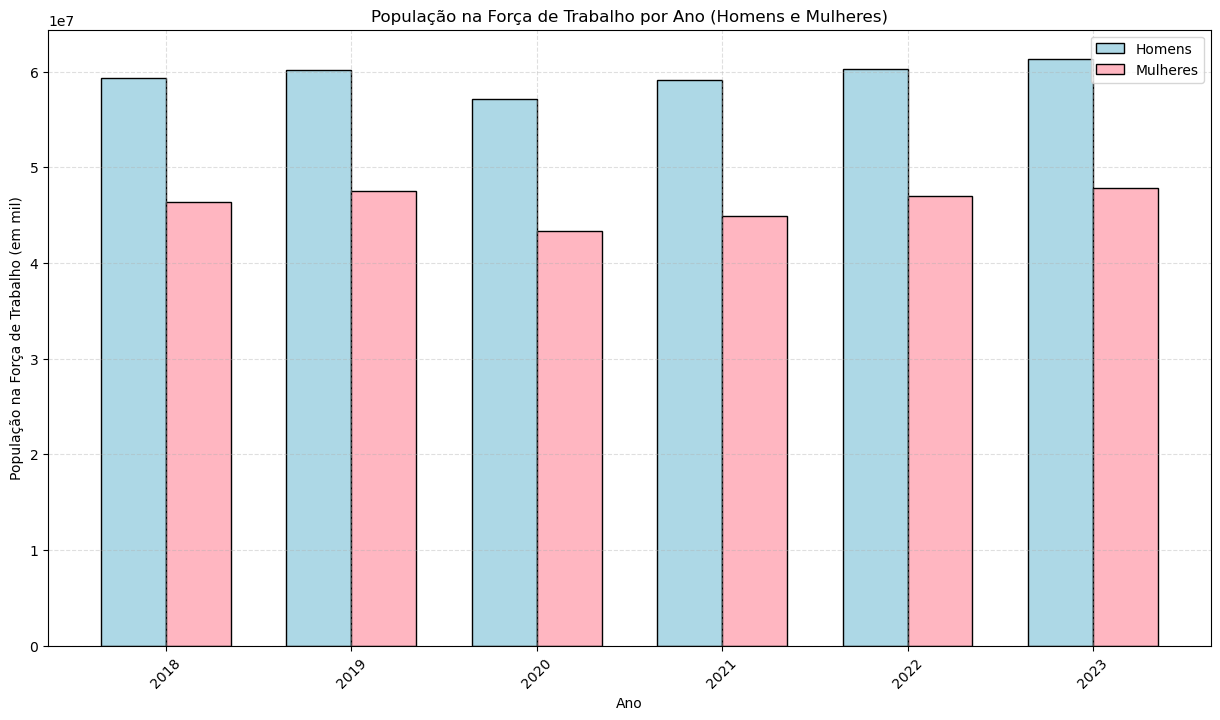

In [115]:
# Criar o gráfico
plt.figure(figsize=(15, 8))

# Definir o número de anos únicos
anos = sorted(socio_filtrado["year"].unique())

# Agrupar os dados por ano e sexo, somando a população
populacao_por_ano_sexo = socio_filtrado.groupby(['year', 'sex'])['work_pop'].sum().unstack()

# Plotar as barras para Homens e Mulheres
largura_barra = 0.35  # Largura das barras
posicoes = range(len(anos))  # Posições das barras

# Barras para Homens
plt.bar([pos - largura_barra / 2 for pos in posicoes], 
        populacao_por_ano_sexo['H'], 
        width=largura_barra, 
        label="Homens", color="lightblue", edgecolor='black')

# Barras para Mulheres
plt.bar([pos + largura_barra / 2 for pos in posicoes], 
        populacao_por_ano_sexo['M'], 
        width=largura_barra, 
        label="Mulheres", color="lightpink", edgecolor='black')

# Adicionar rótulos e título
plt.xlabel("Ano")
plt.ylabel("População na Força de Trabalho (em mil)")
plt.title("População na Força de Trabalho por Ano (Homens e Mulheres)")
plt.xticks(posicoes, anos, rotation=45)  # Exibir os anos no eixo X
plt.grid(True, linestyle="--", alpha=0.4)

# Adicionar a legenda
plt.legend()

# Mostrar o gráfico
plt.show()


### GRÁFICOS - Tabela 3: Perfil socio/econômico TERMINAR

In [ ]:
import matplotlib.pyplot as plt

# Criar o gráfico principal
plt.figure(figsize=(15, 15))
plt.plot(projecoes2_df_filtrado["ANO"], projecoes2_df_filtrado["POP_T"],
         marker="o", linestyle="-", color="b", label="População Total")

# Adicionar valores nos pontos do gráfico
for ano, pop, e0_T, e60_T in zip(projecoes2_df_filtrado["ANO"], 
                                 projecoes2_df_filtrado["POP_T"], 
                                 projecoes2_df_filtrado["e0_T"], 
                                 projecoes2_df_filtrado["e60_T"]):
    plt.text(ano, pop + (pop * 0.0005), f"{pop:,.0f}", 
             ha="center", fontsize=11, color="#444444", fontweight="bold")

    plt.text(ano, pop - (pop * 0.0012), f"({e0_T:,.0f}) | (+{e60_T:,.0f})", 
             ha="center", fontsize=11, color="darkred", fontweight="bold")

# Criar um marcador invisível para incluir na legenda
plt.scatter([], [], color="darkred", label="(e0_T) | (+e60_T)")

# Destacar uma região com transparência (exemplo: entre os anos 2024 e 2045)
plt.axvspan(2024, 2045, color="yellow", alpha=0.2, label="Projeção")

# Personalização
plt.xlabel("Ano")
plt.ylabel("População Total")
plt.title("Projeção Populacional no Brasil (Até 2045)")
plt.xticks(projecoes2_df_filtrado["ANO"], rotation=45)  # Rotacionar anos no eixo x
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

# Mostrar o gráfico
plt.show()
